## CNN with PyTorch

### Load libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load and preprocess the data

In [2]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
file_path = "/content/gdrive/My Drive/cifar/"

def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

def normalize(file):
  return np.reshape(file[b'data'], (len(file[b'data']), 32, 32, 3), order='F').transpose([0,2,1,3]).astype('float32') / 255., np.asarray(file[b'labels']).reshape((len(file[b'labels']), 1))

names = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]

for i in range(6):
  # load data
  file_name = file_path + names[i]
  output = unpickle(file_name)
  # normalize data
  x_batch, y_batch = normalize(output)
  # gather train and test
  if i == 0:
    x_train, y_train = x_batch, y_batch
  elif i != 5:
    x_train = np.concatenate((x_train, x_batch), axis=0)
    y_train = np.concatenate((y_train, y_batch), axis=0)
  else:
    x_test, y_test = x_batch, y_batch

In [4]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


### Show some images from the training dataset

In [65]:
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

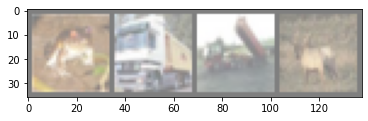

 frog truck truck  deer


In [87]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

x_train_tensor = torch.from_numpy(np.transpose(x_train, (0,3,1,2)))
y_train_tensor = torch.from_numpy(y_train.reshape(-1))
x_test_tensor = torch.from_numpy(np.transpose(x_test, (0,3,1,2)))
y_test_tensor = torch.from_numpy(y_test.reshape(-1))

imshow(torchvision.utils.make_grid(x_train_tensor[:4,:,:,:]))
print(' '.join('%5s' % classes[y_train_tensor[:4][j]] for j in range(4)))

### Define the model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Build the model

In [82]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(12500):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = x_train_tensor[4*(i):4*(i+1),:,:,:], y_train_tensor[4*(i):4*(i+1)]
       
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.959
[1,  4000] loss: 0.999
[1,  6000] loss: 0.993
[1,  8000] loss: 1.009
[1, 10000] loss: 0.995
[1, 12000] loss: 1.018
[2,  2000] loss: 0.902
[2,  4000] loss: 0.929
[2,  6000] loss: 0.957
[2,  8000] loss: 0.935
[2, 10000] loss: 0.996
[2, 12000] loss: 0.980
Finished Training


### Save, load and make predictions with the model

In [97]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

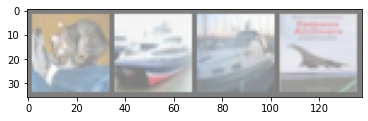

Ground truth:    cat  ship  ship airplane
Predicted:    cat  ship  ship airplane


In [100]:
# print images
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(x_test_tensor[:4,:,:,:])
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(x_test_tensor[:4,:,:,:]))
print('Ground truth: ', ' '.join('%5s' % classes[y_test_tensor[:4][j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

### Prediction accuracy

In [99]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [43]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 74 %
Accuracy of  bird : 48 %
Accuracy of   cat : 45 %
Accuracy of  deer : 37 %
Accuracy of   dog : 53 %
Accuracy of  frog : 75 %
Accuracy of horse : 58 %
Accuracy of  ship : 68 %
Accuracy of truck : 66 %
